Dataset: taiwan, sensitive: sex
Train shape: (18000, 26) Val: (6000, 26) Test: (6000, 26)
lambda=0.00 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.10 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.30 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.50 | Acc=0.818, F1=0.450, MCC=0.387
lambda=1.00 | Acc=0.818, F1=0.450, MCC=0.387

Best lambda on validation (by F1): 0.0

=== Test metrics with best lambda ===
accuracy: 0.8167
precision: 0.6686
recall: 0.3391
f1: 0.4500
mcc: 0.3832
dp_gap: 0.0060
dp_p0: 0.1098
dp_p1: 0.1157
confusion_matrix =
 [[4450  223]
 [ 877  450]]


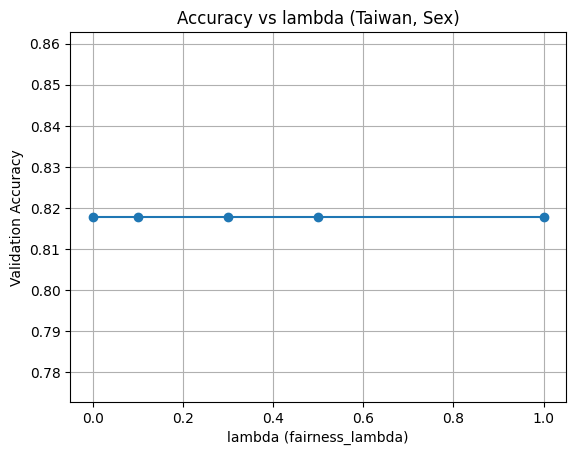

Dataset: taiwan, sensitive: age
Train shape: (18000, 26) Val: (6000, 26) Test: (6000, 26)
lambda=0.00 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.10 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.30 | Acc=0.818, F1=0.450, MCC=0.387
lambda=0.50 | Acc=0.818, F1=0.450, MCC=0.387
lambda=1.00 | Acc=0.818, F1=0.450, MCC=0.387

Best lambda on validation (by F1): 0.0

=== Test metrics with best lambda ===
accuracy: 0.8167
precision: 0.6686
recall: 0.3391
f1: 0.4500
mcc: 0.3832
dp_gap: 0.0312
dp_p0: 0.1276
dp_p1: 0.0965
confusion_matrix =
 [[4450  223]
 [ 877  450]]


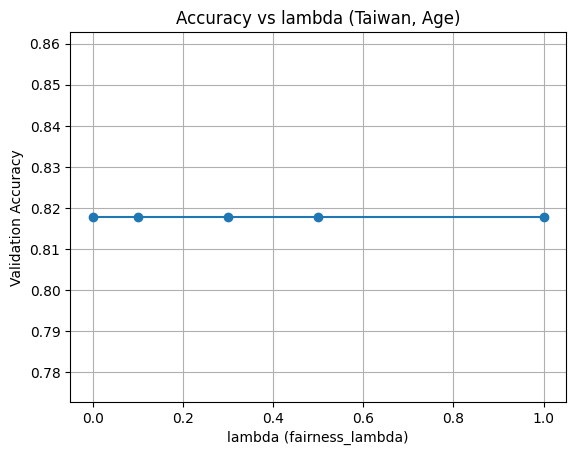

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-8116713405584269>, line 401
    398 plot_tradeoff(val_res_taiwan, title_suffix="(Taiwan, Age)")
    400 # German dataset fairness on sex
--> 401 val_res_german, test_german = run_experiment(
    402     dataset_name="german",
    403     sensitive="sex",
    404     lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    405     n_estimators=40,
    406     dp_tolerance=0.05, # for fairness modifications
    407 )
    408 plot_tradeoff(val_res_german, title_suffix="(German, Sex)")
    410 # German dataset fairness on age

File <command-8116713405584269>, line 304, in run_experiment(dataset_name, sensitive, lambdas, n_estimators, dp_tolerance)
    289 def run_experiment(
    290     dataset_name,
    291     sensitive="sex",
   (...)
    294     dp_tolerance=0.05, # for fairness modifications
    295 ):
    296     '''
    297     Runs the 

In [0]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
# from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

# helpers
def demographic_parity_gap(y_pred, A):
    '''
    todo: function description
    '''
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)

    mask0 = (A == 0)
    mask1 = (A == 1)

    p0 = y_pred[mask0].mean()
    p1 = y_pred[mask1].mean()

    return abs(p1 - p0), p0, p1

def compute_metrics(y_true, y_pred, A):
    '''
    todo: function description
    '''
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    dp_gap, p0, p1 = demographic_parity_gap(y_pred, A)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        "dp_gap": dp_gap,
        "dp_p0": p0,
        "dp_p1": p1,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
    }

# AdaBoost implementation
class AdaBoostClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, 
                 base_estimator=None, 
                 n_estimators=50, 
                 learning_rate=1.0,
                 fairness_lambda=0.0,
                 dp_tolerance=0.0,
                 random_state=None):

        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.fairness_lambda = fairness_lambda
        self.dp_tolerance = dp_tolerance

        self.estimators_ = []
        self.estimator_weights_ = []
        self.classes_ = None

    def check_binary(self, y):
        y = np.asarray(y)
        classes = np.unique(y)
        if len(classes) != 2:
            raise ValueError("Binary classification only.")

        self.classes_ = classes
        return (y == classes[1]).astype(int)

    def fit(self, X, y, A=None):
        X = np.asarray(X)
        y = np.asarray(y)

        y01 = self.check_binary(y)
        n_samples = X.shape[0]

        sample_weight = np.ones(n_samples) / n_samples

        self.estimators_ = []
        self.estimator_weights_ = []

        for t in range(self.n_estimators):

            est = clone(self.base_estimator)
            est.fit(X, y01, sample_weight=sample_weight)

            y_pred = est.predict(X).astype(int)
            incorrect = (y_pred != y01)

            err = np.dot(sample_weight, incorrect) / sample_weight.sum()
            err = np.clip(err, 1e-10, 1 - 1e-10)

            alpha = self.learning_rate * 0.5 * np.log((1 - err) / err)

            if alpha <= 0:
                break

            sample_weight *= np.exp(alpha * incorrect.astype(float))
            sample_weight /= sample_weight.sum()

            self.estimators_.append(est)
            self.estimator_weights_.append(alpha)

        self.estimator_weights_ = np.array(self.estimator_weights_)
        return self

    def scores(self, X):
        X = np.asarray(X)
        scores = np.zeros(X.shape[0])

        for alpha, est in zip(self.estimator_weights_, self.estimators_):
            pred = est.predict(X).astype(int)
            pred_pm1 = 2 * pred - 1
            scores += alpha * pred_pm1

        return scores

    def predict(self, X):
        scores = self.scores(X)
        y01 = (scores >= 0).astype(int)
        return np.where(y01 == 1, self.classes_[1], self.classes_[0])

    def predict_proba(self, X):
        scores = self.scores(X)
        p_pos = 1 / (1 + np.exp(-2 * scores))
        return np.vstack([1 - p_pos, p_pos]).T

# data pre-processing
DATA_DIR = "/Workspace/Users/alexandra.mangune@gmail.com/Masters/AI201/Mini-Project/" # todo: modify this path to match your folder path

def load_taiwan_dataset(test_size=0.2, val_size=0.2, random_state=42, sensitive="sex"):
    '''
    Load the Taiwan dataset (UCI Credit Card).
    sensitive: str, "sex" or "age"
    '''
    path = os.path.join(DATA_DIR, "UCI_Credit_Card.csv")
    df = pd.read_csv(path)
    df = df.drop(columns=["ID"])

    # Target
    y = df["default.payment.next.month"].values

    # Sensitive attributes
    df["SEX_BIN"] = df["SEX"].map({1: 1, 2: 0})
    df["AGE_NUM"] = df["AGE"]
    df["AGE_GROUP"] = pd.cut(
        df["AGE"], bins=[0, 29, 39, 49, 59, 120], labels=[0, 1, 2, 3, 4]
    ).astype(int)

    if sensitive.lower() == "sex":
        A = df["SEX_BIN"].values
    else:
        A = df["AGE_GROUP"].values

    df_features = df.drop(columns=["default.payment.next.month"])
    X = pd.get_dummies(df_features, drop_first=True)

    # train/validate/test split
    X_temp, X_test, y_temp, y_test, A_temp, A_test = train_test_split(
        X, y, A,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )

    val_rel = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val, A_train, A_val = train_test_split(
        X_temp, y_temp, A_temp,
        test_size=val_rel,
        stratify=y_temp,
        random_state=random_state,
    )

    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test,
        scaler,
    )

def load_german_dataset(test_size=0.2, val_size=0.2, random_state=42, sensitive="sex"):
    '''
    Load the German dataset (German Credit).
    sensitive: str, "sex" or "age"
    '''
    path = os.path.join(DATA_DIR, "german_credit_data.csv")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()

    if "risk" in df.columns:
        df["risk_bin"] = df["risk"].map({"good": 0, "bad": 1})
        y = df["risk_bin"].values
        drop_tgt = ["risk", "risk_bin"]
    elif "credit_risk" in df.columns:
        le = LabelEncoder()
        y = le.fit_transform(df["credit_risk"])
        drop_tgt = ["credit_risk"]
    else:
        raise ValueError("Cannot find target column in German dataset")

    if "sex" in df.columns:
        df["sex_bin"] = df["sex"].map({"male": 1, "female": 0})
    else:
        raise ValueError("Expected 'sex' column in German dataset")

    df["age_num"] = df["age"]
    df["age_group"] = pd.cut(
        df["age"], bins=[0, 25, 35, 45, 60, 120], labels=[0, 1, 2, 3, 4]
    ).astype(int)

    if sensitive.lower() == "sex":
        A = df["sex_bin"].values
    else:
        A = df["age_group"].values

    drop_cols = drop_tgt + ["sex", "age"]
    df_features = df.drop(columns=[c for c in drop_cols if c in df.columns])

    X = pd.get_dummies(df_features, drop_first=True)

    # train/val/test split
    X_temp, X_test, y_temp, y_test, A_temp, A_test = train_test_split(
        X, y, A,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )

    val_rel = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val, A_train, A_val = train_test_split(
        X_temp, y_temp, A_temp,
        test_size=val_rel,
        stratify=y_temp,
        random_state=random_state,
    )

    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test,
        scaler,
    )

def load_dataset(name, sensitive="sex", **kwargs):
    '''
    Call either load_taiwan_dataset() or load_german_dataset() functions to load the dataset.
    '''
    if name.lower() == 'taiwan':
        return load_taiwan_dataset(sensitive=sensitive, **kwargs)
    elif name.lower() == 'german':
        return load_german_dataset(sensitive=sensitive, **kwargs)
    else:
        raise ValueError(f"Unknown dataset: {name}")

# run training and testing sets; validate the outputs
def run_experiment(
    dataset_name,
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=50,
    dp_tolerance=0.05, # for fairness modifications
):
    '''
    Runs the experiment for a given dataset and sensitive attribute.
    '''
    (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test, # this is for the fairness modifications
        scaler,
    ) = load_dataset(dataset_name, sensitive=sensitive)

    print(f"Dataset: {dataset_name}, sensitive: {sensitive}")
    print("Train shape:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

    base = DecisionTreeClassifier(max_depth=1)  # stump; change if you want

    val_results = []

    for lam in lambdas:
        model = AdaBoostClassifier(
            base_estimator=base,
            n_estimators=n_estimators,
            learning_rate=1.0,
            fairness_lambda=lam, # for fairness modifications
            dp_tolerance=dp_tolerance # for fairness modifications
        )
        # model.fit(X_train, y_train)
        model.fit(X_train, y_train, A_train)
        y_val_pred = model.predict(X_val)

        metrics = compute_metrics(y_val, y_val_pred, A_val)
        metrics["lambda"] = lam
        val_results.append(metrics)

        print(
            f"lambda={lam:.2f} | "
            f"Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, "
            f"MCC={metrics['mcc']:.3f}"
        )

    best_idx = np.argmax([m["f1"] for m in val_results])
    best_lam = val_results[best_idx]["lambda"]
    print("\nBest lambda on validation (by F1):", best_lam)

    X_tr_full = pd.concat([X_train, X_val], axis=0)
    y_tr_full = np.concatenate([y_train, y_val])
    A_tr_full = np.concatenate([A_train, A_val])

    best_model = AdaBoostClassifier(
        base_estimator=base,
        n_estimators=n_estimators,
        learning_rate=1.0,
        fairness_lambda=best_lam,
        dp_tolerance=dp_tolerance,
    )
    best_model.fit(X_tr_full, y_tr_full, A_tr_full)
    y_test_pred = best_model.predict(X_test)

    test_metrics = compute_metrics(y_test, y_test_pred, A_test)
    print("\n=== Test metrics with best lambda ===")
    for k, v in test_metrics.items():
        if k == "confusion_matrix":
            print(k, "=\n", v)
        else:
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return val_results, test_metrics

# plot figures
def plot_tradeoff(val_results, title_suffix=""):
    '''
    Plot the tradeoff between accuracy and demographic parity gap.
    '''
    lambdas = [m["lambda"] for m in val_results]
    acc = [m["accuracy"] for m in val_results]

    plt.figure()
    plt.plot(lambdas, acc, marker="o")
    plt.xlabel("lambda (fairness_lambda)")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Accuracy vs lambda {title_suffix}")
    plt.grid(True)
    plt.show()
# run experiments

# Taiwan dataset fairness on sex
val_res_taiwan, test_taiwan = run_experiment(
    dataset_name="taiwan",
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=40,
    dp_tolerance=0.05, # for fairness modifications
)
plot_tradeoff(val_res_taiwan, title_suffix="(Taiwan, Sex)")

# Taiwan dataset fairness on age
val_res_taiwan, test_taiwan = run_experiment(
    dataset_name="taiwan",
    sensitive="age",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=40,
    dp_tolerance=0.05, # for fairness modifications
)
plot_tradeoff(val_res_taiwan, title_suffix="(Taiwan, Age)")

# German dataset fairness on sex
val_res_german, test_german = run_experiment(
    dataset_name="german",
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=40,
    dp_tolerance=0.05, # for fairness modifications
)
plot_tradeoff(val_res_german, title_suffix="(German, Sex)")

# German dataset fairness on age
val_res_german, test_german = run_experiment(
    dataset_name="german",
    sensitive="age",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=40,
    dp_tolerance=0.05, # for fairness modifications
)
plot_tradeoff(val_res_german, title_suffix="(German, Age)")